# Introduction

In this tutorial, we demonstrate how to use Monocle 3 (alpha release) to resolve multiple disjoint trajectories.   

# How to install and use Monocle 3 
Intructions to use Monocle 3: 
1. Make sure you've upgrade to R 3.5
2. Update to the latest release version of Monocle 2 through bioconductor in order to  pull in most of the dendencies:

source("https://bioconductor.org/biocLite.R")

biocLite("monocle")

3. Install DDRTree (simple-ppt-like branch) from our GitHub repo: 

devtools::install_github("cole-trapnell-lab/DDRTree", ref="simple-ppt-like")

4. Install the latest version of L1-graph from our GitHub repo:

devtools::install_github("cole-trapnell-lab/L1-graph")

5. Install several python packages Monocle 3 depends on:

install.packages("reticulate")

library(reticulate)

py_install("umap-learn")

py_install("louvain")

5. Then pull the monocle3_beta_release branch of the monocle-dev. Build it (use R CMD build) and install it (use R CMD install) 

devtools::install_github("cole-trapnell-lab/monocle-release", ref="monocle3_beta_release")

You may find that some depdencies are not automatically installed. If so, try to source them from bioconductor using biocLite().

# The Monocle 3 workflow 
![work](./workflow.png)

Monocle 3 takes as input an expression matrix and, depdending on how you run it, can produce several outputs:

1. A set of clusters and assignments of each cell to a cluster
2. A collection of single-cell trajectories and for each cell a position on a trajectory
3. Visualizations of the cells that help interpet their type and state
4. Various types of differential expression analyses (e.g. cluster-specific markers, genes associated with fate decisions, etc).

To analyze a single-cell dataset, Monocle first normalizes expression values to account for technical variation in RNA recovery and sequencing depth. Next, to eliminate noise and make downstream computations more tractable, it projects each cell onto the top 50 (by default) principal components. Then, you as the user choose whether to reduce the dimensionality further using one of two non-linear methods for dimensionality reduction: `t-SNE` or `UMAP`. The former is an extremely popular and widely accepted technique for visualizing single-cell RNA-seq data. The latter is faster, and often better preserves the global structure of the data but is also newer and therefore less well tested by the single-cell community. Then, Monocle 3 will cluster your cells, organize them into trajectories, or both.

Monocle 3 can learn multiple disconnected or "disjoint" trajectories. This is important because many experiments will capture a community of cells that are responding to a stimulus or undergoing differentiation, with each type of cell responding differently. Where Monocle 2 would incorrectly force them all into a single trajectory, Monocle 3 can detect that some cells are part of a different process than others in the dataset. Monocle 3 achieves this by "partitioning" the cells into "supergroups" using a method derived from "approximate graph abstraction" (AGA) (Wolf et al, 2017). Cells from different supergroups cannot be part of the same trajectory.

Monocle 3 provides three different ways to organize cells into trajectories, all of which are based on the concept of "principal graph embedding". `DDRTree` is the method used in Monocle 2 to learn tree-like trajectories, and has received some important updates in Monocle 3. `SimplePPT` works similarly to `DDRTree` in that it learns a tree-like trajectory, but it does not attempt to further reduce the dimensionality of the data. `L1Graph` is an advanced optimization method that can learn trajectories that have loops in them (that is, trajectories that aren't trees).

Once this is complete, you can run tests for genes that are specific to each cluster, find genes that vary over the course of a trajectory, and plot your data in many different ways. Monocle 3 provides a suite of regression tests to find genes that differ between clusters and over trajectories. Monocle 3 also introduces a new test that uses the principal graph directly and can help find genes that vary in complex ways over a trajectory with loops and more intricate structures.

In [1]:
rm(list = ls()) # clear the environment 
#load all the necessary libraries 
options(warn=-1) # turn off warning message globally 
library(monocle)

Loading required package: Matrix
Loading required package: DelayedArray
Loading required package: stats4
Loading required package: matrixStats
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:Matrix’:

    colMeans, colSums, rowMeans, rowSums, which

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pma

# Analyzing the data from Paul et al. with Monocle 3 

First let's load up the data from Paul et. al, which explored hematopoeisis at single-cell resolution. To save time, we'll just load a CellDataSet object. Monocle 3 makes some changes to the CellDataSet class, so we'll call a function to "upgrade" the old object to the new format. Finally, we'll adjust one of the factor levels to make the cell types easier to read.

In [2]:
#cds <- readRDS('data/valid_subset_GSE72857_cds2.RDS')
cds <- readRDS(gzcon(url("http://trapnell-lab.gs.washington.edu/public_share/valid_subset_GSE72857_cds2.RDS")))
pData(cds)$cell_type2 <- plyr::revalue(as.character(pData(cds)$cluster), 
                                                              c("1" = 'Erythrocyte', 
                                                                "2" = 'Erythrocyte', 
                                                                "3" = 'Erythrocyte', 
                                                                "4" = 'Erythrocyte', 
                                                                "5" = 'Erythrocyte', 
                                                                "6" = 'Erythrocyte', 
                                                                "7" = 'Multipotent progenitors', 
                                                                "8" = 'Megakaryocytes', 
                                                                "9" = 'GMP', 
                                                                "10" = 'GMP',
                                                                "11" = 'Dendritic cells', 
                                                                "12" = 'Basophils', 
                                                                "13" = 'Basophils', 
                                                                "14" = 'Monocytes', 
                                                                "15" = 'Monocytes', 
                                                                "16" = 'Neutrophils', 
                                                                "17" = 'Neutrophils', 
                                                                "18" = 'Eosinophls', 
                                                                "19" = 'lymphoid'))
detailed_cell_type_color <- c("Basophils" = "#E088B8", "Dendritic cells" = "#46C7EF", "Eosinophls" = "#EFAD1E", "Erythrocyte" = "#8CB3DF", "Monocytes" = "#53C0AD", "Multipotent progenitors" = "#4EB859", "GMP" = "#D097C4", "Megakaryocytes" = "#ACC436", "Neutrophils" = "#F5918A", 'NA' = '#000080')

# the definitiion of CellDataset in Monocle 3 has been updated, update old CDS with the updateCDS function 
cds <- updateCDS(cds) 

# Pass TRUE if you want to see progress output on some of Monocle 3's operations
DelayedArray:::set_verbose_block_processing(TRUE)

# Passing a higher value will make some computations faster but use more memory. Adjust with caution!
options(DelayedArray.block.size=1000e6)

The following `from` values were not present in `x`: 19


[1] FALSE

We then estimate size factors for each cell and dispersion function for the genes in the cds as usual. Monocle 3 now performs these operations using the DelayedArray packages so they work on datasets with millions of cells. 

In [3]:
cds <- estimateSizeFactors(cds)
cds <- estimateDispersions(cds)

Processing block 1/1 ... OK
Removing 18 outliers


Next, run the `preprocessCDS()` function to project the data into lower PCA space:

In [4]:
cds <- preprocessCDS(cds, num_dim = 20)

Processing block 1/1 ... OK


Then, apply a further round of (nonlinear) dimensionality reduction using UMAP:

In [5]:
cds <- reduceDimension(cds, reduction_method = 'UMAP', python_home = "/Users/xqiu/.virtualenvs/r-reticulate/bin/python")

Now we're ready to start learning trajectories!

# Learning disjoint trajectories with SimplePPT

Rather than forcing all cells into a single developmental trajectory, Monocle 3 enables you to learn a *set* of trajectories that describe the biological process you're studying. For example, if you're looking at a community of immune cells responding to infection, each cell type will respond to antigen (and each other) in a different way, so they should be organized into distinct trajectories.

In Monocle 3, we recognize "disjoint" trajectories by drawing on ideas from Alex Wolf and colleagues, who recently introduced the concept of abstract graph participation. Monocle 3 implements the test for cell community connectedness from Wolf et al via the `partitionCells()` function, which divides the cells into "supergroups".

In [6]:
cds <- partitionCells(cds)

Now that the cells are paritioned, we can organize each supergroup into a separate trajectory. The default method for doing this in Monocle 3 is `SimplePPT`, which assumes that each trajectory is a tree (albeit one that may have multiple roots). Learn these trees with the `learnGraph` function:

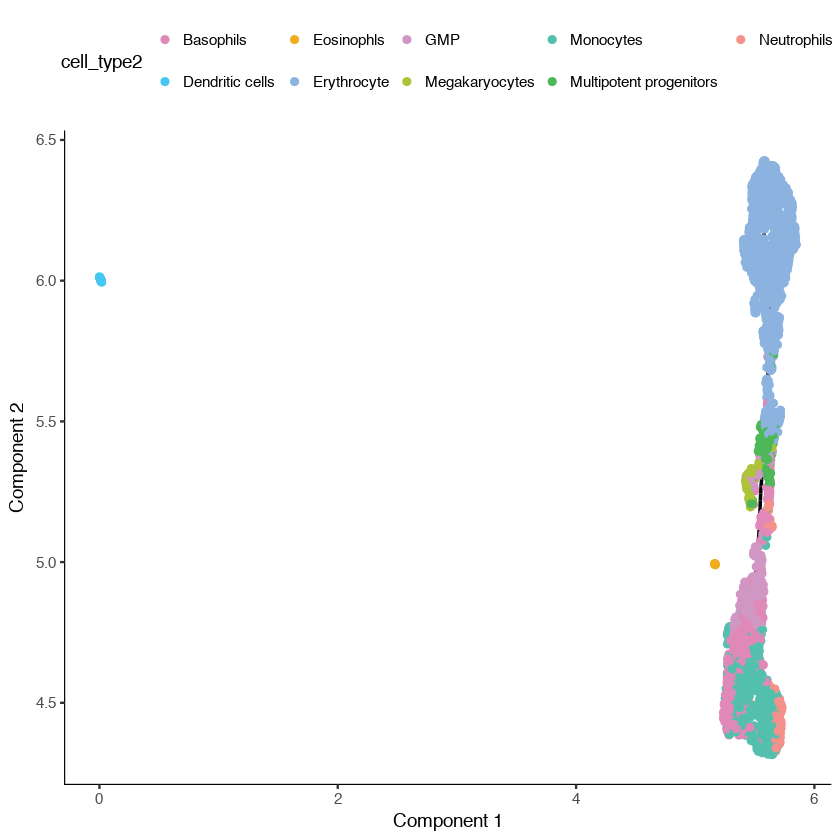

In [7]:
cds <- learnGraph(cds,  RGE_method = 'SimplePPT')
plot_cell_trajectory(cds, color_by = "cell_type2") + scale_color_manual(values = detailed_cell_type_color)

You can see that Monocle has learned two trajectories, one of which is tiny and essentially trivial. The other has one major branch. SimplePPT essentially is finding a principal graph that fits nicely within the cells as projected in the UMAP coordinate space.

# Defining the starting point(s) for trajectories

In the trajectory above, you can see that the "Multipotent progenitor" cells are located roughly in the middle of the longer trajectory segment. We know from extensive past study of hematopoeisis that these are the "root" cell state that generates all the others in the primary trajectory. We need to tell Monocle that these cells are the "beginning" of the trajectory. In Monocle 2, this wouldn't be possible, because the software required that the root be one of the leaves of the tree. Monocle 3 allows you to specify an internal part of the tree as the root.  There are two ways to do this:

1. You can specifiy the name of a specific cell or principal graph node as the root by passing it to `orderCells()`.
2. You can call `orderCells()` with no root specified and it will open a window for you to select the root(s) with your mouse cursor. This latter option is only available in interactive sessions, and doesn't work in Jupyter notebooks.

Once you select one or more roots, `orderCells()` computes the shortest path from each cell's location on the princiapl graph to the nearest root node. That is, a cell's pseudotime value is the *geodesic distance* from it to the nearest root, traveling over the graph. Any cell that is not reachable from some root will be assigned a pseudotime value of infinity.

You may find it helpful to automatically pick the root according to any number of biologically-driven criteria. For example, you could find the nodes at which cells expressing a certain marker gene are concentrated. Or could select the node where cells from an early experimental timepoint land. Here, we provide one such helper function to show you how to do this kind of thing:

In [8]:
# a helper function to identify the root principal points: 
get_correct_root_state <- function(cds, cell_phenotype, root_type){
  cell_ids <- which(pData(cds)[, cell_phenotype] == root_type)

  closest_vertex <- cds@auxOrderingData[[cds@dim_reduce_type]]$pr_graph_cell_proj_closest_vertex
  closest_vertex <- as.matrix(closest_vertex[colnames(cds), ])  
  root_pr_nodes <- V(cds@minSpanningTree)$name[as.numeric(names(which.max(table(closest_vertex[cell_ids,]))))]
    
  root_pr_nodes
}

In the above function, we are accessing `pr_graph_cell_proj_closest_vertex` which is just a list that stores for each cell, the ID of the principal graph node it's closest to. This is handle for computing statistics (e.g. with `dplyr`) about the principal graph nodes and which cells of what type map to them.

Now we can call this function to automatically find the node in the principal graph where our multipotent progenitors reside:

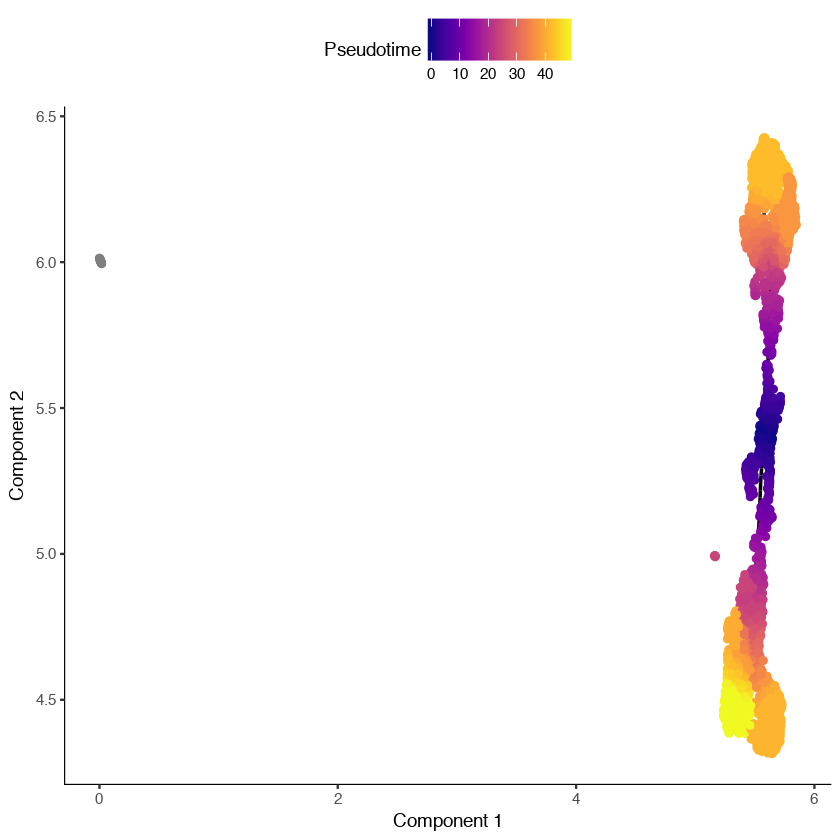

In [9]:
MPP_node_ids = get_correct_root_state(cds, cell_phenotype = 'cell_type2', "Multipotent progenitors")
cds <- orderCells(cds, root_pr_nodes = MPP_node_ids)
plot_cell_trajectory(cds) 

# Learning and visualizing trajectories in 3D

Sometimes, projecting cells into three dimensions instead of two can make the biological process you're studying easier to interpret. In Monocle 3, we provide the `plot_3d_cell_trajectory` function to plot a dataset in 3 dimensions. The block of code below shows you how to learn a trajectory in 3D:

- Reduces the data down into three dimensions using UMAP
- Learns and the trajectory trajectory and orders the cells 
- Visualizes the 3D trajectory 

In [10]:
cds <- reduceDimension(cds, max_components = 3,  
                       python_home = "/Users/xqiu/.virtualenvs/r-reticulate/bin/python",
                       reduction_method = 'UMAP',
                       metric="cosine", 
                       verbose = F)

cds <- partitionCells(cds)

cds <- learnGraph(cds, max_components = 3, RGE_method = 'SimplePPT', partition_component = T, 
                  verbose = F)

cds <- orderCells(cds, 
                  root_pr_nodes = get_correct_root_state(cds, 
                                                         cell_phenotype = 'cell_type2', 
                                                         "Multipotent progenitors"))
                     
plot_3d_cell_trajectory(cds, 
                        color_by="cell_type2", 
                        webGL_filename=paste(getwd(), "/trajectory_3D.html", sep=""), 
                        palette=detailed_cell_type_color,
                        show_backbone=TRUE, 
                        useNULL_GLdev=TRUE)


Joining, by = "sample_name"
Loading required namespace: rmarkdown


HTML widgets cannot be represented in plain text (need html)

# Identifying genes that vary over a trajectory 

We are often interested in finding genes that are differentially expressed across a single-cell trajectory. Monocle 3 introduces a new approach for finding such genes that draws on a powerful technique in spatial correlation analysis, the Moran’s I test. Moran’s I is a measure of multi-directional and multi-dimensional spatial autocorrelation. The statistic tells you whether cells at nearby positions on a trajectory will have similar (or dissimilar) expression levels for the gene being tested. Although both Pearson correlation and Moran’s I ranges from -1 to 1, the interpretation of Moran’s I is slightly different: +1 means that nearby cells will have perfectly similar expression (as in the right panel below); 0 represents no correlation (center), and -1 means that neighboring cells will be *anti-correlated* (left). 

![Moran_I](./moran_I.png)

In Monocle 3, we implement Moran's I through the `principalGraphTest` function:

In [11]:
pr_graph_test <- principalGraphTest(cds, k=3, cores=1)

We can easily view the top differentially expressed genes as follows:

In [12]:
dplyr::add_rownames(pr_graph_test) %>% 
    dplyr::arrange(plyr::desc(morans_test_statistic), plyr::desc(-qval)) %>% head(3) 

rowname,status,pval,morans_test_statistic,morans_I,gene_short_name,qval
H2-Eb1,OK,0,52.96833,0.7819415,H2-Eb1,0
Mt2,OK,0,49.47827,0.7442805,Mt2,0
Ermap,OK,0,49.20773,0.7402118,Ermap,0


You can check out the test results for one or more genes like this:

In [13]:
pr_graph_test[fData(cds)$gene_short_name %in% c("Hbb-b1"),]

,status,pval,morans_test_statistic,morans_I,gene_short_name,qval
Hbb-b1,OK,1.588077e-189,29.34031,0.4398584,Hbb-b1,6.444589e-188


We can see that overall, there are more than 2,300 DE genes over the whole trajectory:

In [14]:
nrow(subset(pr_graph_test, qval < 0.01))

[1] 2385

# Plotting gene expression levels in 3D trajectories

Once you've identified differentially expressed genes, you'll often want to visualize their expression levels on the trajectory. The plot bleow shows each cell with detectable levels of Hbb-b1 superimposed on the trajectory. Values are log-transformed and scaled into Z scores. Cells with no expression are not shown to avoid overplotting.

In [15]:
plot_3d_cell_trajectory(cds, markers = c('Hbb-b1'),
                        webGL_filename=paste(getwd(), "beta_globin.html", sep=""), 
                        show_backbone=TRUE, 
                        useNULL_GLdev=TRUE)

HTML widgets cannot be represented in plain text (need html)

In [16]:
sessionInfo()

R version 3.5.0 (2018-04-23)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS High Sierra 10.13.3

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
 [1] splines   parallel  stats4    stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] bindrcpp_0.2.2        monocle_2.99.0        L1Graph_0.1.0        
 [4] lpSolveAPI_5.5.2.0-17 igraph_1.2.1          DDRTree_0.1.5        
 [7] irlba_2.3.2           VGAM_1.0-5            ggplot2_2.2.1        
[10] Biobase_2.40.0        DelayedArray_0.6.0    BiocParallel_1.14.1  
[13] IRanges_2.14.10       S4Vectors_0.18.2      BiocGenerics_0.26.0  
[16] matrixStats_0.53.1    Matrix_1.2-14        

loaded via a namespace (and not attached):
 [1] nlme